# Lecture 10 worksheet

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pymc3 as pm
from pymc3 import glm
import statsmodels.api as sm
import arviz

sns.set()
sns.set_context('notebook')

## Question 1: Fitting a multi-dimensional model

In lecture, you saw how to fit a 1-dimensional regression model in two different ways:
* Bayesian regression using PyMC3 to find the (approximate) posterior distribution over the coefficients
* Frequentist regression using statsmodels to find the estimated coefficients

In this question, you'll extend the analyses from lecture into multi-dimensional regression.

For each question, you should produce similar output (plots, etc.) to what was produced in lecture.

In [4]:
turbines = pd.read_csv('turbines.csv')
# The "year" column contains how many years since the year 2000
turbines['year'] = turbines['p_year'] - 2000
turbines = turbines.drop('p_year', axis=1)
turbines.head()

# Turbines in Oklahoma (where the wind comes sweepin' down the plain...)
ok_filter = (turbines.t_state == 'OK') & (turbines.year >= 0)
ok_turbines = turbines[ok_filter].sort_values('year')
ok_turbines["totals"] = np.cumsum(ok_turbines["t_built"])
# Log-transform the counts, too
ok_turbines["log_totals"] = np.log(ok_turbines["totals"])

In [5]:
ok_turbines

,t_state,t_built,t_cap,year,totals,log_totals
361,OK,1,100.0,1.0,1,0.000000
362,OK,113,176250.0,3.0,114,4.736198
363,OK,182,298200.0,5.0,296,5.690359
364,OK,40,60000.0,6.0,336,5.817111
365,OK,85,154500.0,7.0,421,6.042633
366,OK,91,141900.0,8.0,512,6.238325
367,OK,153,299100.0,9.0,665,6.499787
368,OK,195,352260.0,10.0,860,6.756932
369,OK,257,524900.0,11.0,1117,7.018402
370,OK,596,1127050.0,12.0,1713,7.446001


In [7]:
ok_turbines['log_cap'] = np.log(ok_turbines['t_cap'])
ok_turbines

,t_state,t_built,t_cap,year,totals,log_totals,log_cap
361,OK,1,100.0,1.0,1,0.000000,4.605170
362,OK,113,176250.0,3.0,114,4.736198,12.079659
363,OK,182,298200.0,5.0,296,5.690359,12.605520
364,OK,40,60000.0,6.0,336,5.817111,11.002100
365,OK,85,154500.0,7.0,421,6.042633,11.947949
366,OK,91,141900.0,8.0,512,6.238325,11.862878
367,OK,153,299100.0,9.0,665,6.499787,12.608533
368,OK,195,352260.0,10.0,860,6.756932,12.772125
369,OK,257,524900.0,11.0,1117,7.018402,13.170963
370,OK,596,1127050.0,12.0,1713,7.446001,13.935114


### Q1.1

The column `t_cap` in the turbines dataset contains the total power capacity available from wind turbines built in that year.

Write PyMC3 code to predict log(total capacity) from year and number of turbines (using `t_built`). Compare using a normal likelihood model to a Student $t$ likelihood model. What changes and why?

### Answer

To find out how to add another variable to the model, the two best ways are to (1) look at the documentation for the code you're using, and (2) search online.

Here, if we start with (1), and look at the help for `glm.GLM.from_formula?`, we see that the formula used is called a "`patsy`" formula. The documentation for that package tells us that we can just use `y ~ a + b` to add more variables, so that's what we'll do:

In [8]:
# Bayesian regression model using Gaussian likelihood (equivalent to OLS)

with pm.Model() as gaussian_model:
    glm.GLM.from_formula('log_cap ~ year + t_built', ok_turbines)
    # draw posterior samples using NUTS sampling
    gaussian_trace = pm.sample(1000, cores=2, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, t_built, year, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.


How do we change to the Student $t$ likelihood? We know that when we changed between Gaussian, Poisson, and Negative Binomial, we used a different argument for the `family` parameter.

So here, we can search for terms like "PyMC3 GLM Student t family", or even start typing `glm.families.` and tab-complete to see if the student t distribution is already there.

In [10]:
# Bayesian regression model using Gaussian likelihood (equivalent to OLS)

with pm.Model() as t_model:
    glm.GLM.from_formula(
        'log_cap ~ year + t_built', ok_turbines, family=glm.families.StudentT(),
    )
    # draw posterior samples using NUTS sampling
    t_trace = pm.sample(1000, cores=2, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, t_built, year, Intercept]


/opt/conda/lib/python3.8/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 24 seconds.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'year'}>],
       [<AxesSubplot:title={'center':'t_built'}>,
        <AxesSubplot:title={'center':'t_built'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

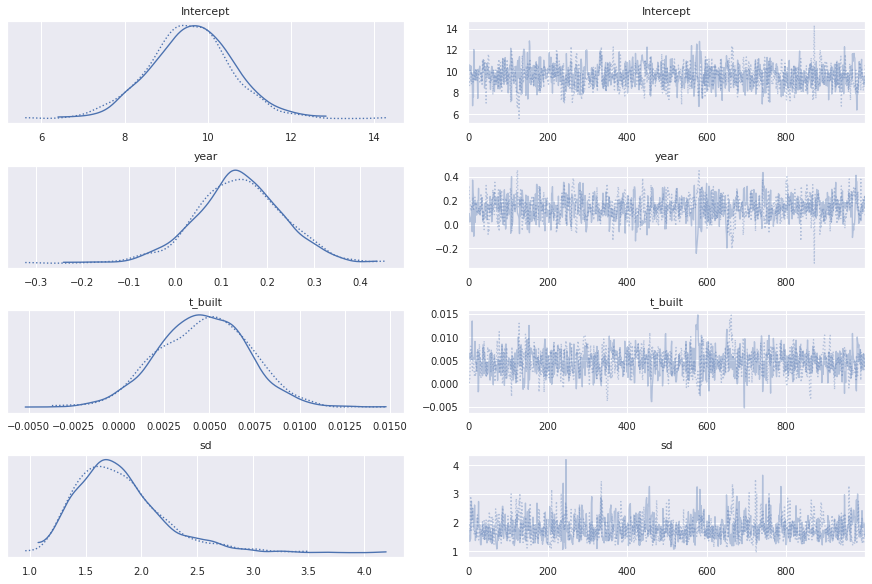

In [9]:
arviz.plot_trace(gaussian_trace)

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'year'}>],
       [<AxesSubplot:title={'center':'t_built'}>,
        <AxesSubplot:title={'center':'t_built'}>],
       [<AxesSubplot:title={'center':'lam'}>,
        <AxesSubplot:title={'center':'lam'}>]], dtype=object)

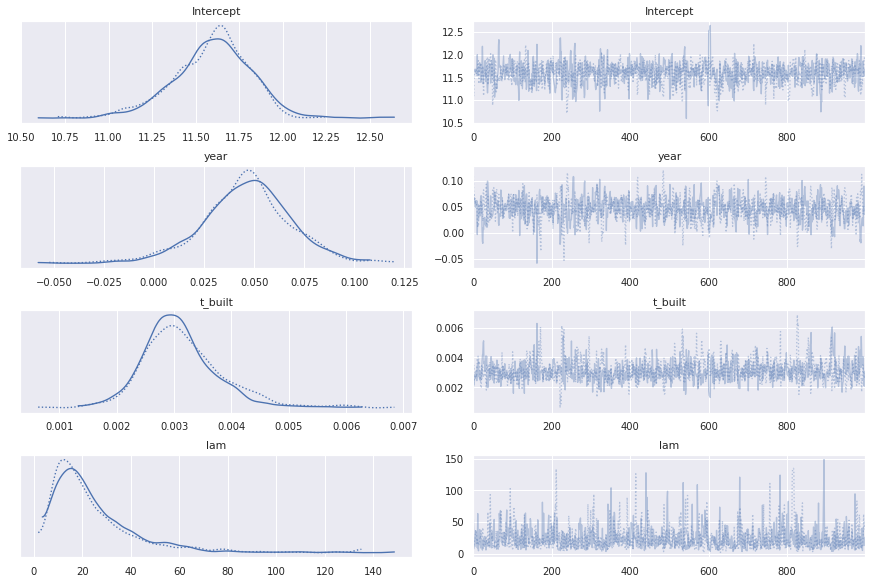

In [11]:
arviz.plot_trace(t_trace)

The results have a higher intercept and smaller slopes. Because the $t$ distribution has heavier tails, it's less sensitive to outliers.

### Q1.2

Repeat the previous part, but using frequentist inference in statsmodels.

### Answer

To add another variable in statsmodels, again we can start by looking at the documentation: `sm.GLM?`

This tells us that the second argument can be a "`nobs x k`" array, with one row per observation and one column per regressor. So, we can just pass in the following:

In [13]:
ok_turbines[['year', 't_built']]

,year,t_built
361,1.0,1
362,3.0,113
363,5.0,182
364,6.0,40
365,7.0,85
366,8.0,91
367,9.0,153
368,10.0,195
369,11.0,257
370,12.0,596


In [15]:
gaussian_model_intercept = sm.GLM(
    ok_turbines.log_cap, sm.add_constant(ok_turbines[['year', 't_built']]),
    family=sm.families.Gaussian()
)
gaussian_results = gaussian_model_intercept.fit()
print(gaussian_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                log_cap   No. Observations:                   17
Model:                            GLM   Df Residuals:                       14
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          2.6501
Method:                          IRLS   Log-Likelihood:                -30.756
Date:                Thu, 18 Feb 2021   Deviance:                       37.101
Time:                        10:51:28   Pearson chi2:                     37.1
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5557      0.886     10.788      0.0

Unfortunately statsmodels does not have a student t likelihood for regression. There's a `use_t` parameter in the fit method, but it doesn't have any documentation describing what it does.

### Q1.3

Interpret the coefficients you found in Q1.1 above. Your answers should look something like this:

* (COEFFICIENT): If (VARIABLE) changes by (AMOUNT), then (OTHER VARIABLE) (HOW IT CHANGES)

**Answer**:

In [4]:
(np.exp(0.12), np.exp(0.005))

(1.1274968515793757, 1.005012520859401)

* Coefficient for `year`: if `year` changes by 1 (and `t_built` stays the same), then `t_cap` increases by a factor of $e^{0.12} = 1.13$.
* Coefficient for `t_built`: if `t_built` changes by 1 (and `year` stays the same), then `t_cap` increases by a factor of $e^{0.005} = 1.001$.

These interpretations are the true output of the model, but they're not particularly intuitive! We know that increased capacity is caused by building more turbines, not by just sitting by and letting time pass. But in our dataset, the variables that we're using to predict (`year` and `t_built`) are *strongly* correlated, which we saw in lecture. So, it only makes sense to reason about the prediction from both of them together.

### Q1.4

List at least five different problems or concerns you have with the analysis/results from Q1.1.

**Answer**:

## Question 2: Likelihood, loss functions, and logistic regression

Suppose that we assume the likelihood model for each $y_i$ is Bernoulli with parameter $\sigma(\beta^T x_i)$. Show that maximizing the likelihood is equivalent to minimizing the binary cross-entropy loss.

*Hint*: remember that maximizing the likelihood is exactly equivalent to minimizing the negative log-likelihood.

### Answer

From the definition of the Bernoulli distribution that we've already seen, the likelihood is:

$$
p(y|\beta) = \left[\sigma(\beta^T x_i)\right]^{y_i} \left[1-\sigma(\beta^T x_i)\right]^{1-y_i}
$$

Just as we did before (see the regression review notebook for more), instead of maximizing the likelihood, we'll minimize the negative log-likelihood (since these two operations are the same).

\begin{align}
\beta^* 
    &= \text{argmin}_\beta -\log \left(\left[\sigma(\beta^T x_i)\right]^{y_i} \left[1-\sigma(\beta^T x_i)\right]^{1-y_i}\right) \\
    &= \text{argmin}_\beta -\left[ y_i\log \sigma(\beta^T x_i) + (1-y_i)\log\left(1-\sigma(\beta^T x_i)\right)\right] \\
\end{align}

This is exactly equal to the cross-entropy loss.